# Method 7 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

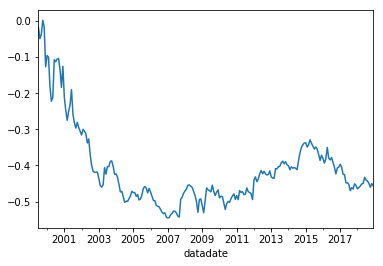

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.126932
2000-12-31    0.001588
2001-12-31   -0.205917
2002-12-31   -0.162408
2003-12-31   -0.010977
2004-12-31   -0.081301
2005-12-31    0.015217
2006-12-31   -0.148364
2007-12-31    0.144929
2008-12-31   -0.030105
2009-12-31    0.049117
2010-12-31   -0.049619
2011-12-31   -0.000796
2012-12-31    0.157191
2013-12-31    0.028980
2014-12-31    0.099858
2015-12-31   -0.050898
2016-12-31   -0.052600
2017-12-31   -0.084940
2018-12-31   -0.002507
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     5.877
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000161
Time:                        22:01:05   Log-Likelihood:                 496.46
No. Observations:                 234   AIC:                            -982.9
Df Residuals:                     229   BIC:                            -965.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.381      0.169      -0.007       0.001
mktrf          0.0915      0.055      1.674      0.096      -0.016       0.199
me             0.1363      0.064      2.144      0.033       0.011       0.262
ia             0.0918      0.097      0.950      0.343      -0.099       0.282
roe           -0.1288      0.083     -1.557      0.121      -0.292       0.034
==============================================================================
Omnibus:                       30.706   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.812
Skew:                           0.355   Prob(JB):                     8.77e-30
Kurtosis:                       6.636   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     5.177
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000520
Time:                        22:01:05   Log-Likelihood:                 496.46
No. Observations:                 234   AIC:                            -982.9
Df Residuals:                     229   BIC:                            -965.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.342      0.180      -0.007       0.001
mktrf          0.0915      0.065      1.413      0.158      -0.035       0.218
me             0.1363      0.065      2.110      0.035       0.010       0.263
ia             0.0918      0.110      0.831      0.406      -0.125       0.308
roe           -0.1288      0.099     -1.305      0.192      -0.322       0.065
==============================================================================
Omnibus:                       30.706   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.812
Skew:                           0.355   Prob(JB):                     8.77e-30
Kurtosis:                       6.636   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.275
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.28e-05
Time:                        22:01:05   Log-Likelihood:                 496.46
No. Observations:                 234   AIC:                            -982.9
Df Residuals:                     229   BIC:                            -965.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.277      0.202      -0.007       0.001
mktrf          0.0915      0.051      1.796      0.072      -0.008       0.191
me             0.1363      0.064      2.143      0.032       0.012       0.261
ia             0.0918      0.107      0.856      0.392      -0.118       0.302
roe           -0.1288      0.082     -1.565      0.117      -0.290       0.032
==============================================================================
Omnibus:                       30.706   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.812
Skew:                           0.355   Prob(JB):                     8.77e-30
Kurtosis:                       6.636   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5.384
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000106
Time:                        22:01:05   Log-Likelihood:                 498.08
No. Observations:                 234   AIC:                            -984.2
Df Residuals:                     228   BIC:                            -963.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.473      0.142      -0.007       0.001
mktrf          0.1195      0.055      2.191      0.029       0.012       0.227
smb            0.1175      0.072      1.633      0.104      -0.024       0.259
hml           -0.1371      0.085     -1.617      0.107      -0.304       0.030
rmw           -0.1055      0.096     -1.100      0.272      -0.294       0.083
cma            0.2317      0.122      1.901      0.059      -0.009       0.472
==============================================================================
Omnibus:                       26.543   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.236
Skew:                           0.258   Prob(JB):                     7.01e-25
Kurtosis:                       6.338   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.779
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00262
Time:                        22:01:05   Log-Likelihood:                 498.08
No. Observations:                 234   AIC:                            -984.2
Df Residuals:                     228   BIC:                            -963.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.508      0.132      -0.007       0.001
mktrf          0.1195      0.053      2.258      0.024       0.016       0.223
smb            0.1175      0.077      1.529      0.126      -0.033       0.268
hml           -0.1371      0.102     -1.344      0.179      -0.337       0.063
rmw           -0.1055      0.080     -1.321      0.186      -0.262       0.051
cma            0.2317      0.125      1.858      0.063      -0.013       0.476
==============================================================================
Omnibus:                       26.543   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.236
Skew:                           0.258   Prob(JB):                     7.01e-25
Kurtosis:                       6.338   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.155
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00124
Time:                        22:01:05   Log-Likelihood:                 498.08
No. Observations:                 234   AIC:                            -984.2
Df Residuals:                     228   BIC:                            -963.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.472      0.141      -0.007       0.001
mktrf          0.1195      0.051      2.320      0.020       0.019       0.220
smb            0.1175      0.071      1.665      0.096      -0.021       0.256
hml           -0.1371      0.093     -1.473      0.141      -0.320       0.045
rmw           -0.1055      0.073     -1.446      0.148      -0.248       0.037
cma            0.2317      0.120      1.928      0.054      -0.004       0.467
==============================================================================
Omnibus:                       26.543   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.236
Skew:                           0.258   Prob(JB):                     7.01e-25
Kurtosis:                       6.338   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     5.370
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000376
Time:                        22:01:05   Log-Likelihood:                 495.52
No. Observations:                 234   AIC:                            -981.0
Df Residuals:                     229   BIC:                            -963.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.438      0.152      -0.007       0.001
mktrf          0.1071      0.051      2.120      0.035       0.008       0.207
smb            0.1667      0.063      2.642      0.009       0.042       0.291
hml           -0.0528      0.063     -0.842      0.400      -0.176       0.071
umd           -0.0271      0.041     -0.660      0.510      -0.108       0.054
==============================================================================
Omnibus:                       28.296   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.598
Skew:                           0.208   Prob(JB):                     4.86e-31
Kurtosis:                       6.761   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     4.765
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00104
Time:                        22:01:05   Log-Likelihood:                 495.52
No. Observations:                 234   AIC:                            -981.0
Df Residuals:                     229   BIC:                            -963.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.486      0.137      -0.007       0.001
mktrf          0.1071      0.067      1.597      0.110      -0.024       0.239
smb            0.1667      0.074      2.259      0.024       0.022       0.311
hml           -0.0528      0.067     -0.788      0.431      -0.184       0.079
umd           -0.0271      0.081     -0.335      0.738      -0.186       0.132
==============================================================================
Omnibus:                       28.296   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.598
Skew:                           0.208   Prob(JB):                     4.86e-31
Kurtosis:                       6.761   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     5.656
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000233
Time:                        22:01:05   Log-Likelihood:                 495.52
No. Observations:                 234   AIC:                            -981.0
Df Residuals:                     229   BIC:                            -963.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.416      0.157      -0.007       0.001
mktrf          0.1071      0.055      1.944      0.052      -0.001       0.215
smb            0.1667      0.062      2.693      0.007       0.045       0.288
hml           -0.0528      0.059     -0.896      0.370      -0.168       0.063
umd           -0.0271      0.068     -0.401      0.689      -0.160       0.106
==============================================================================
Omnibus:                       28.296   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.598
Skew:                           0.208   Prob(JB):                     4.86e-31
Kurtosis:                       6.761   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     4.681
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00155
Time:                        22:01:05   Log-Likelihood:                 237.40
No. Observations:                 120   AIC:                            -464.8
Df Residuals:                     115   BIC:                            -450.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.003     -1.717      0.089      -0.012       0.001
mktrf          0.1484      0.088      1.684      0.095      -0.026       0.323
me             0.1761      0.087      2.024      0.045       0.004       0.349
ia             0.1901      0.136      1.395      0.166      -0.080       0.460
roe           -0.1192      0.121     -0.989      0.325      -0.358       0.120
==============================================================================
Omnibus:                       15.817   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.484
Skew:                           0.335   Prob(JB):                     8.06e-11
Kurtosis:                       5.974   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     5.311
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000582
Time:                        22:01:05   Log-Likelihood:                 237.40
No. Observations:                 120   AIC:                            -464.8
Df Residuals:                     115   BIC:                            -450.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.003     -1.606      0.108      -0.012       0.001
mktrf          0.1484      0.110      1.350      0.177      -0.067       0.364
me             0.1761      0.088      2.004      0.045       0.004       0.348
ia             0.1901      0.134      1.416      0.157      -0.073       0.453
roe           -0.1192      0.152     -0.785      0.432      -0.417       0.178
==============================================================================
Omnibus:                       15.817   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.484
Skew:                           0.335   Prob(JB):                     8.06e-11
Kurtosis:                       5.974   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     6.835
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.69e-05
Time:                        22:01:05   Log-Likelihood:                 237.40
No. Observations:                 120   AIC:                            -464.8
Df Residuals:                     115   BIC:                            -450.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.004     -1.472      0.141      -0.013       0.002
mktrf          0.1484      0.080      1.854      0.064      -0.009       0.305
me             0.1761      0.090      1.967      0.049       0.001       0.352
ia             0.1901      0.128      1.480      0.139      -0.062       0.442
roe           -0.1192      0.128     -0.931      0.352      -0.370       0.132
==============================================================================
Omnibus:                       15.817   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.484
Skew:                           0.335   Prob(JB):                     8.06e-11
Kurtosis:                       5.974   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.189
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00157
Time:                        22:01:05   Log-Likelihood:                 238.47
No. Observations:                 120   AIC:                            -464.9
Df Residuals:                     114   BIC:                            -448.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.003     -1.692      0.093      -0.012       0.001
mktrf          0.2113      0.092      2.284      0.024       0.028       0.394
smb            0.1657      0.105      1.582      0.117      -0.042       0.373
hml           -0.1939      0.128     -1.511      0.134      -0.448       0.060
rmw           -0.0184      0.151     -0.122      0.903      -0.318       0.281
cma            0.3281      0.166      1.979      0.050      -0.000       0.657
==============================================================================
Omnibus:                       11.824   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.539
Skew:                           0.065   Prob(JB):                     5.21e-08
Kurtosis:                       5.587   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     3.604
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00460
Time:                        22:01:05   Log-Likelihood:                 238.47
No. Observations:                 120   AIC:                            -464.9
Df Residuals:                     114   BIC:                            -448.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.003     -1.638      0.101      -0.012       0.001
mktrf          0.2113      0.091      2.317      0.021       0.033       0.390
smb            0.1657      0.113      1.469      0.142      -0.055       0.387
hml           -0.1939      0.126     -1.545      0.122      -0.440       0.052
rmw           -0.0184      0.117     -0.157      0.875      -0.248       0.211
cma            0.3281      0.158      2.074      0.038       0.018       0.638
==============================================================================
Omnibus:                       11.824   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.539
Skew:                           0.065   Prob(JB):                     5.21e-08
Kurtosis:                       5.587   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.529
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000838
Time:                        22:01:05   Log-Likelihood:                 238.47
No. Observations:                 120   AIC:                            -464.9
Df Residuals:                     114   BIC:                            -448.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.004     -1.559      0.119      -0.013       0.001
mktrf          0.2113      0.087      2.438      0.015       0.041       0.381
smb            0.1657      0.109      1.526      0.127      -0.047       0.378
hml           -0.1939      0.115     -1.687      0.092      -0.419       0.031
rmw           -0.0184      0.118     -0.156      0.876      -0.249       0.213
cma            0.3281      0.151      2.175      0.030       0.032       0.624
==============================================================================
Omnibus:                       11.824   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.539
Skew:                           0.065   Prob(JB):                     5.21e-08
Kurtosis:                       5.587   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.006
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00444
Time:                        22:01:05   Log-Likelihood:                 236.17
No. Observations:                 120   AIC:                            -462.3
Df Residuals:                     115   BIC:                            -448.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.003     -1.569      0.119      -0.011       0.001
mktrf          0.1755      0.078      2.238      0.027       0.020       0.331
smb            0.1756      0.089      1.966      0.052      -0.001       0.352
hml           -0.0291      0.089     -0.325      0.745      -0.206       0.148
umd            0.0178      0.055      0.323      0.747      -0.091       0.127
==============================================================================
Omnibus:                       14.549   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               52.496
Skew:                           0.023   Prob(JB):                     3.99e-12
Kurtosis:                       6.240   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     3.148
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0170
Time:                        22:01:05   Log-Likelihood:                 236.17
No. Observations:                 120   AIC:                            -462.3
Df Residuals:                     115   BIC:                            -448.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.003     -1.631      0.103      -0.011       0.001
mktrf          0.1755      0.109      1.615      0.106      -0.037       0.388
smb            0.1756      0.092      1.909      0.056      -0.005       0.356
hml           -0.0291      0.079     -0.367      0.714      -0.185       0.126
umd            0.0178      0.102      0.175      0.861      -0.181       0.217
==============================================================================
Omnibus:                       14.549   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               52.496
Skew:                           0.023   Prob(JB):                     3.99e-12
Kurtosis:                       6.240   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     3.630
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00799
Time:                        22:01:05   Log-Likelihood:                 236.17
No. Observations:                 120   AIC:                            -462.3
Df Residuals:                     115   BIC:                            -448.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.003     -1.552      0.121      -0.011       0.001
mktrf          0.1755      0.076      2.297      0.022       0.026       0.325
smb            0.1756      0.081      2.180      0.029       0.018       0.333
hml           -0.0291      0.067     -0.435      0.663      -0.160       0.102
umd            0.0178      0.079      0.224      0.823      -0.138       0.173
==============================================================================
Omnibus:                       14.549   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               52.496
Skew:                           0.023   Prob(JB):                     3.99e-12
Kurtosis:                       6.240   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7403
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.566
Time:                        22:01:05   Log-Likelihood:                 270.90
No. Observations:                 114   AIC:                            -531.8
Df Residuals:                     109   BIC:                            -518.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.148      0.882      -0.004       0.005
mktrf          0.0167      0.068      0.247      0.805      -0.117       0.151
me             0.1191      0.104      1.141      0.256      -0.088       0.326
ia            -0.0345      0.145     -0.238      0.812      -0.321       0.252
roe           -0.0529      0.127     -0.416      0.678      -0.305       0.199
==============================================================================
Omnibus:                       25.205   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.720
Skew:                           0.894   Prob(JB):                     9.69e-12
Kurtosis:                       5.735   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                     1.351
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.256
Time:                        22:01:05   Log-Likelihood:                 270.90
No. Observations:                 114   AIC:                            -531.8
Df Residuals:                     109   BIC:                            -518.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.167      0.867      -0.004       0.004
mktrf          0.0167      0.058      0.290      0.772      -0.096       0.130
me             0.1191      0.088      1.346      0.178      -0.054       0.292
ia            -0.0345      0.153     -0.226      0.821      -0.334       0.265
roe           -0.0529      0.124     -0.428      0.668      -0.295       0.189
==============================================================================
Omnibus:                       25.205   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.720
Skew:                           0.894   Prob(JB):                     9.69e-12
Kurtosis:                       5.735   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                     1.401
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.239
Time:                        22:01:05   Log-Likelihood:                 270.90
No. Observations:                 114   AIC:                            -531.8
Df Residuals:                     109   BIC:                            -518.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.160      0.873      -0.004       0.004
mktrf          0.0167      0.050      0.332      0.740      -0.082       0.115
me             0.1191      0.090      1.328      0.184      -0.057       0.295
ia            -0.0345      0.173     -0.199      0.842      -0.374       0.305
roe           -0.0529      0.133     -0.399      0.690      -0.313       0.207
==============================================================================
Omnibus:                       25.205   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.720
Skew:                           0.894   Prob(JB):                     9.69e-12
Kurtosis:                       5.735   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.5400
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.746
Time:                        22:01:05   Log-Likelihood:                 270.78
No. Observations:                 114   AIC:                            -529.6
Df Residuals:                     108   BIC:                            -513.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.070      0.944      -0.004       0.005
mktrf          0.0208      0.065      0.321      0.749      -0.108       0.149
smb            0.1249      0.105      1.187      0.238      -0.084       0.334
hml           -0.0198      0.134     -0.147      0.883      -0.286       0.246
rmw           -0.0186      0.164     -0.113      0.910      -0.344       0.307
cma            0.0600      0.209      0.288      0.774      -0.354       0.473
==============================================================================
Omnibus:                       26.906   Durbin-Watson:                   2.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.939
Skew:                           0.934   Prob(JB):                     4.32e-13
Kurtosis:                       5.915   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.8361
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.527
Time:                        22:01:05   Log-Likelihood:                 270.78
No. Observations:                 114   AIC:                            -529.6
Df Residuals:                     108   BIC:                            -513.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.080      0.936      -0.004       0.004
mktrf          0.0208      0.047      0.441      0.659      -0.072       0.113
smb            0.1249      0.117      1.066      0.286      -0.105       0.355
hml           -0.0198      0.088     -0.224      0.823      -0.193       0.153
rmw           -0.0186      0.155     -0.120      0.904      -0.323       0.286
cma            0.0600      0.139      0.432      0.666      -0.212       0.332
==============================================================================
Omnibus:                       26.906   Durbin-Watson:                   2.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.939
Skew:                           0.934   Prob(JB):                     4.32e-13
Kurtosis:                       5.915   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.8751
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.500
Time:                        22:01:05   Log-Likelihood:                 270.78
No. Observations:                 114   AIC:                            -529.6
Df Residuals:                     108   BIC:                            -513.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.075      0.940      -0.004       0.004
mktrf          0.0208      0.041      0.514      0.607      -0.059       0.100
smb            0.1249      0.124      1.005      0.315      -0.119       0.369
hml           -0.0198      0.083     -0.240      0.811      -0.182       0.142
rmw           -0.0186      0.133     -0.140      0.889      -0.280       0.242
cma            0.0600      0.163      0.368      0.713      -0.259       0.379
==============================================================================
Omnibus:                       26.906   Durbin-Watson:                   2.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.939
Skew:                           0.934   Prob(JB):                     4.32e-13
Kurtosis:                       5.915   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.891
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.117
Time:                        22:01:05   Log-Likelihood:                 273.20
No. Observations:                 114   AIC:                            -536.4
Df Residuals:                     109   BIC:                            -522.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.388      0.699      -0.004       0.005
mktrf         -0.0003      0.063     -0.005      0.996      -0.125       0.124
smb            0.1314      0.098      1.343      0.182      -0.063       0.325
hml           -0.0648      0.101     -0.643      0.522      -0.265       0.135
umd           -0.1727      0.076     -2.271      0.025      -0.323      -0.022
==============================================================================
Omnibus:                       12.185   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.722
Skew:                           0.523   Prob(JB):                     0.000142
Kurtosis:                       4.624   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.557
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.191
Time:                        22:01:05   Log-Likelihood:                 273.20
No. Observations:                 114   AIC:                            -536.4
Df Residuals:                     109   BIC:                            -522.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.360      0.719      -0.004       0.006
mktrf         -0.0003      0.066     -0.004      0.996      -0.129       0.128
smb            0.1314      0.093      1.410      0.159      -0.051       0.314
hml           -0.0648      0.127     -0.512      0.609      -0.313       0.183
umd           -0.1727      0.105     -1.644      0.100      -0.379       0.033
==============================================================================
Omnibus:                       12.185   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.722
Skew:                           0.523   Prob(JB):                     0.000142
Kurtosis:                       4.624   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.435
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0515
Time:                        22:01:05   Log-Likelihood:                 273.20
No. Observations:                 114   AIC:                            -536.4
Df Residuals:                     109   BIC:                            -522.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.336      0.737      -0.004       0.006
mktrf         -0.0003      0.064     -0.005      0.996      -0.125       0.124
smb            0.1314      0.098      1.347      0.178      -0.060       0.323
hml           -0.0648      0.133     -0.486      0.627      -0.326       0.196
umd           -0.1727      0.098     -1.766      0.077      -0.364       0.019
==============================================================================
Omnibus:                       12.185   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.722
Skew:                           0.523   Prob(JB):                     0.000142
Kurtosis:                       4.624   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""